In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
# from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, RocCurveDisplay, roc_auc_score
from sklearn.preprocessing import LabelEncoder

# Description:
- 

# Data:
- https://archive.ics.uci.edu/dataset/20/census+income - variables for weather a person makes above or less then 50 thousand dollers a year.

In [133]:
seed = 42
ycols = ['income']
xcols = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
         'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
         'hours-per-week', 'native-country']

all_cols = xcols.copy()
all_cols.append(*ycols)
df = pd.read_csv("..\\..\\data\\consensus_income\\adult.data", names=all_cols, na_values='?', engine='python', sep=', ')

X = df[xcols]

le = LabelEncoder()
Y = le.fit_transform(df[ycols].values.ravel())

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)

all_names =[]
all_perf = {'F1':[],
            'AUC':[]}

Y

array([0, 0, 0, ..., 0, 0, 1], shape=(32561,))

In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  31978 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'fnlwgt'}>],
       [<Axes: title={'center': 'education-num'}>,
        <Axes: title={'center': 'capital-gain'}>],
       [<Axes: title={'center': 'capital-loss'}>,
        <Axes: title={'center': 'hours-per-week'}>]], dtype=object)

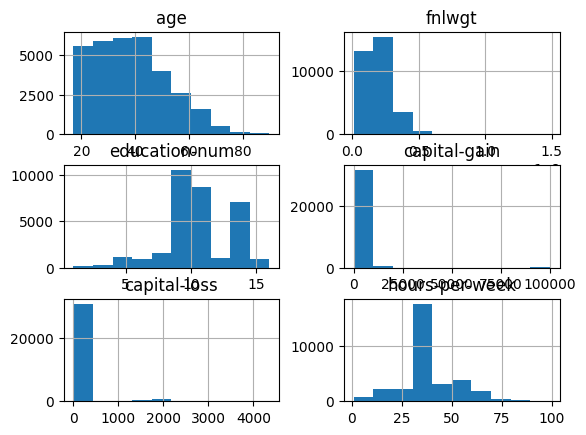

In [135]:
df.hist()

In [136]:
def get_predictions(model):
    # train the model on the features (X) and target labels (Y)
    model.fit(X_train, Y_train)
    # with the trained model, take in the test values and try to predict some Y values
    prediction = model.predict(X_test)
    return get_table(model, prediction)

#separated because of gridCV pedantics
def get_table(model, prediction):
    # creates a data frame with one column ("pred") that stores all of the predictions
    out_df = pd.DataFrame(columns=['pred'], data=prediction)
    # append the data frame with a new column ("prob") that holds the
    # calculated probability of each value by the model
    out_df['prob'] = model.predict_proba(X_test)[:,1]
    return out_df

def evaluate(preds, name):
    f1 = f1_score(Y_test, preds['pred'])
    auc = roc_auc_score(Y_test, preds['prob'])

    print("\n", name, ": ")
    print(classification_report(preds['pred'], Y_test))
    print("F1 = ", f1)
    print("AUC = ", auc)

    print()
    all_names.append(name)
    all_perf['F1'].append(f1)
    all_perf['AUC'].append(auc)

def graph_ROC(predictions):
    RocCurveDisplay.from_predictions(Y_test, predictions['prob'])
    plt.grid()
    plt.axis('equal')
    plt.show()

In [137]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

num_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
cat_cols = [x for x in xcols if x not in num_cols]

pre_num = Pipeline([
    ('scaler', StandardScaler()),
    ('impute', SimpleImputer(strategy='median'))
])

pre_cat = Pipeline([
    ('code', OneHotEncoder()),
    ('impute', SimpleImputer(strategy='most_frequent'))
])

pre = ColumnTransformer([
    ('num', pre_num, num_cols),
    ('cat', pre_cat, cat_cols)
])

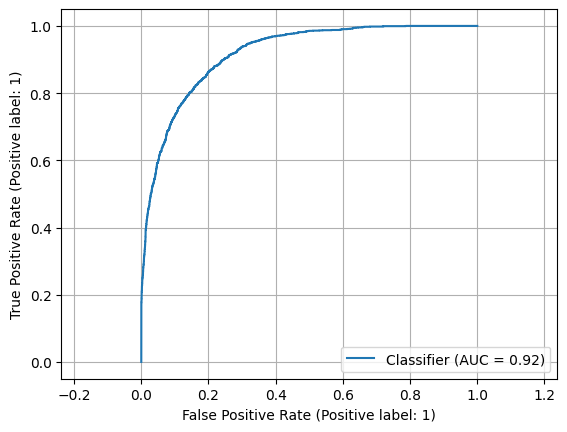


 Random forest classifier : 
              precision    recall  f1-score   support

           0       0.95      0.88      0.91      5294
           1       0.61      0.79      0.69      1219

    accuracy                           0.87      6513
   macro avg       0.78      0.84      0.80      6513
weighted avg       0.88      0.87      0.87      6513

F1 =  0.6867383512544802
AUC =  0.9179671329368478



In [138]:
from sklearn.ensemble import RandomForestClassifier
rfc = Pipeline([
    ('pre', pre),
    ('model', RandomForestClassifier(n_estimators=100,
                                     min_samples_split=20,
                                     min_samples_leaf=5,
                                     n_jobs=1))
])
name = 'Random forest classifier'
p_rfc = get_predictions(rfc)
graph_ROC(p_rfc)
evaluate(p_rfc, name)

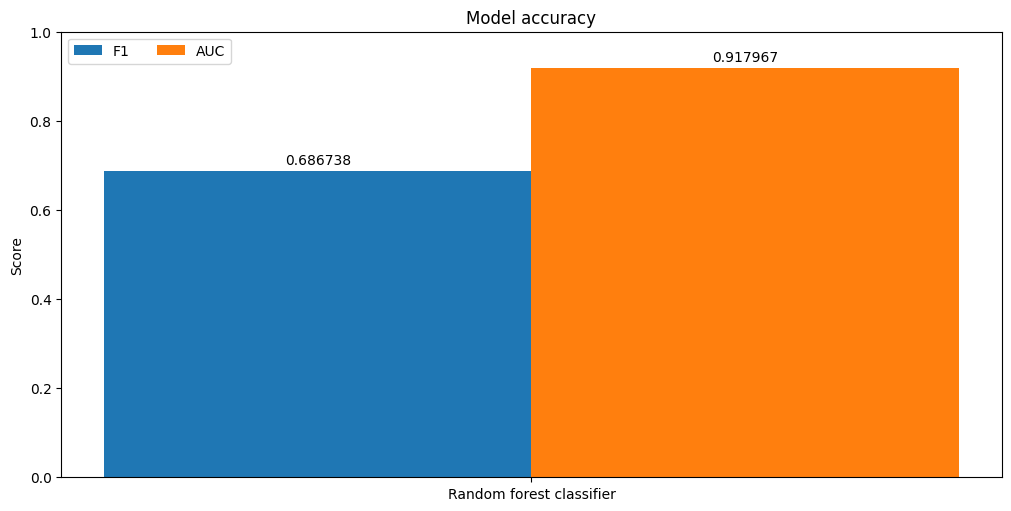

In [139]:
x = np.arange(len(all_names))
width = 0.25
multiplier = 0.5

fig, ax = plt.subplots(layout = 'constrained', figsize = (10, 5))

for attribute, measurement in all_perf.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label = attribute)
    ax.bar_label(rects, padding = 3)
    multiplier +=1

ax.set_ylabel('Score')
ax.set_title('Model accuracy')
ax.set_xticks(x + width, all_names)
ax.legend(loc='upper left', ncols=2)
ax.set_ylim(0, 1)

plt.show()